## 주식 예측에 도전해 보자  
### ARIMA를 이용한 시계열 데이터 예측
종가 기준 시계열 데이터를 예측한다  


step1. 시계열 데이터 준비  
칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)
  
step2. 각종 전처리 수행  
결측치 처리  
로그 변환  
  
step 3. 시계열 안정성 분석
정성적 그래프 분석
정량적 Augmented Dicky-Fuller Test
시계열 분해(Time Series Decomposition)
Residual 안정성 확인  
  
step4. 학습, 테스트 데이터셋 생성
  
step5. 적정 ARIMA모수 찾기
ACF, PACF 그려보기 -> p,q 구하기
차분 안정성 확인 -> d 구하기  
  
step 6. ARIMA 모델 훈련과 테스트

step 7. 다른 주식 종목 예측해 보기

step 1. 시계열 데이터 준비  
과제의 요구사항은 '종가'를 예측하는 것이다.   

In [1]:
# 필요 모듈 import
import pandas as pd
import numpy as np
import sklearn
import statsmodels
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 데이터 경로에서 파일 불러오기
data_path='.\ess_data\ARIMA_stock_prediction'
sam_path=os.path.join(data_path, '005930KS.csv')
sam_data=pd.read_csv(sam_path, index_col='Date')
print(sam_data.shape)
sam_data.head(10)

(250, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
2020-05-25,48750.0,48900.0,48450.0,48850.0,46836.773438,14337913
2020-05-26,48700.0,49450.0,48600.0,49250.0,47220.289063,15127490
2020-05-27,48950.0,50000.0,48800.0,49900.0,47843.500000,19548479
2020-05-28,51100.0,51200.0,49900.0,50400.0,48322.898438,31309318


In [3]:
sam_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7+ KB


step2. 각종 전처리 수행  
결측값, 중복값 확인, 처리 및 그래프 관찰과 로그 변환을 진행하였다.

In [4]:
# 결측값 확인
sam_close=sam_data['Close']
sam_close.isna().sum()

0

In [5]:
# 중복값 확인
sam_data.duplicated()[sam_data.duplicated()==True]

Series([], dtype: bool)

<AxesSubplot:xlabel='Close', ylabel='Density'>

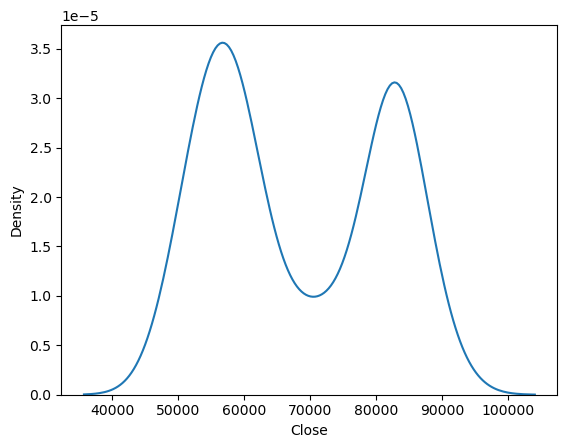

In [6]:
# 그래프 그리기: close만 실행
sns.kdeplot(sam_close)

In [7]:
print(sam_close.skew())
print(sam_close.kurt())

0.15618549819653754
-1.6353091861844875


데이터의 왜도(skewness)와 첨도(kurtosis)를 구하였을 때, 둘 다 절대값이 크지 않으며, 위와 같은 형태의 분포에 적용하는 것을 확인하기 어려워 log는 적용하지 않았다.

step 3. 시계열 안정성 분석  
시계열 data가 얼마나 starionary한지 확인하기 위해 정성적 그래프 분석부터 시작하였다.  

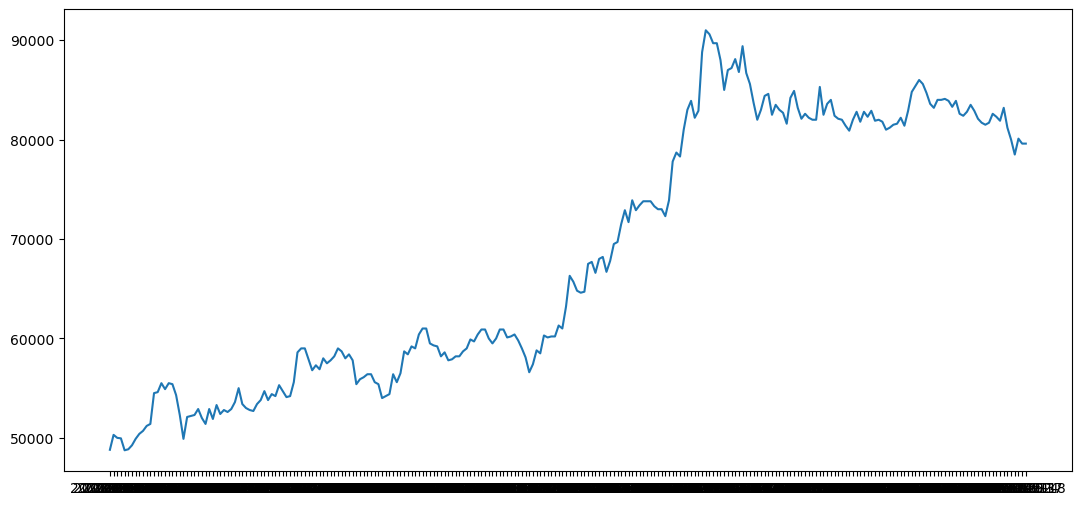

In [8]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6  
plt.plot(sam_close)

In [9]:
def plot_rolling_statistics(timeseries, window=5):
    rolmean= timeseries.rolling(window=window).mean()
    rolstd= timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

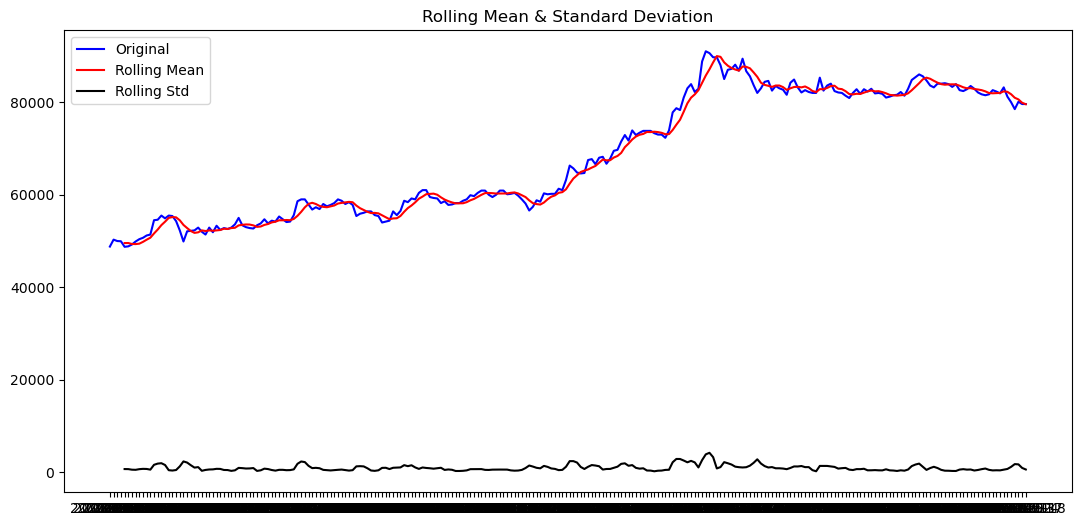

In [10]:
plot_rolling_statistics(sam_close, window=5)

그래프로 확인해 보았을 때, 시간의 흐름에 따라 이동표준편차는 다소 안정적으로 보여지나, 이동평규는 증가하다가 감소하는 추세를 보이고 있다. 그러므로 삼성전자의 주가는 stationary 하다고 보기는 어려울 것 같다.  
좀 더 정밀한 판단을 위하여, adf test를 시행하고 p 값을 확인해 보기로 하였다.  


In [11]:
from statsmodels.tsa.stattools import adfuller

# 
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(sam_close)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


adf test의 p-value값은 0.6637로 stationary와는 거리가 먼 값을 보였다. 값을 더욱 안정시키기 위해

시계열 분해(Time Series Decomposition)  
Residual 안정성 확인  

In [13]:
sam_log=np.log1p(sam_close)

In [14]:
augmented_dickey_fuller_test(sam_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383522
p-value                          0.590150
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


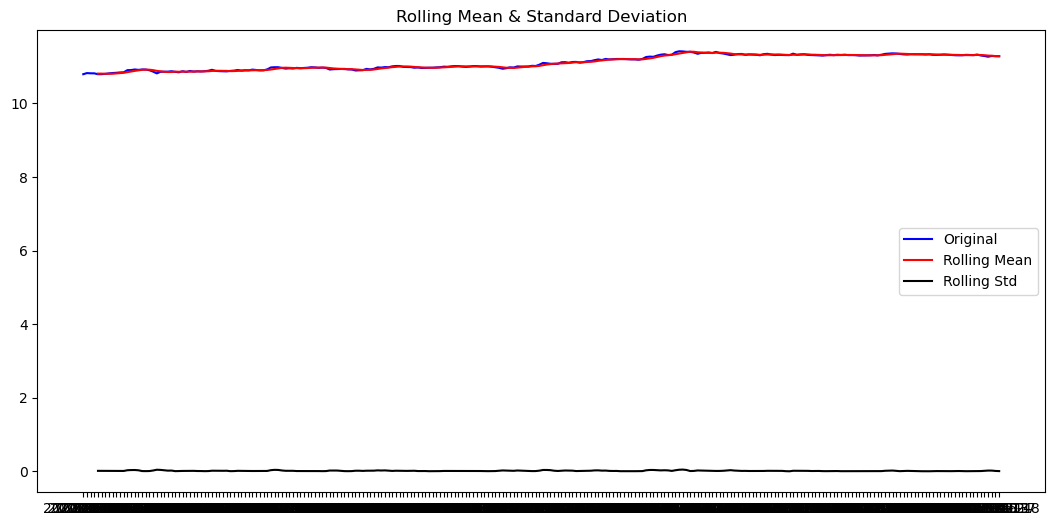

In [19]:
plot_rolling_statistics(sam_log, window=5)

0.07정도 p-value가 줄어들었다. 물론 skewness나 kurtosis가 높지 않았기 때문에 두 값을 수정하여 p-value를 높이는 로그 적용은 p-value에 큰 영향을 미치지 못하는 것 같다. 그래프로 보았을 때는 상당히 일정해 보이기는 하지만 시각적 판단보다는 p-value가 더 정확하다고 보았기 때문에 추가로 trend(추세)를 상쇄하여 p-value를 좀 더 줄여보기로 하였다.

In [15]:
# sam_log에서 이동평균값을 빼주면 추세를 상쇄시킬 수 있다.
sam_log_mov_avg=sam_log-sam_log.rolling(window=5).mean()
# 이동평균 빼주며 발생하는 NaN값 제거
sam_log_mov_avg.dropna(inplace=True)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22   -0.016392
                ...   
2021-05-12   -0.021185
2021-05-13   -0.030658
2021-05-14   -0.006037
2021-05-17   -0.003452
2021-05-18    0.000528
Name: Close, Length: 250, dtype: float64

In [18]:
augmented_dickey_fuller_test(sam_log_mov_avg)

Results of Dickey-Fuller Test:
Test Statistic                -7.801632e+00
p-value                        7.466391e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


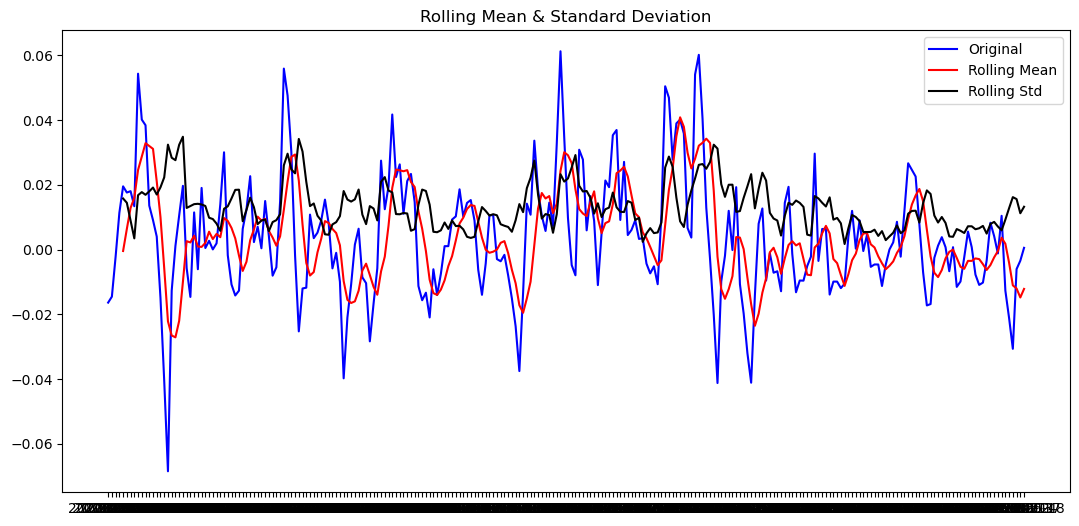

In [20]:
plot_rolling_statistics(sam_log_mov_avg, window=5)

압도적으로 p-value가 줄은 것을 확인할 수 있었다. 7.466391e-12=7.466391*(10**(-12))로 상당히 작은 값이로 변하였으며, 그래프상으로는 아까보다 상당히 어지러워 보이지만 y축의 단위를 보면 전보다 훨씬 stationary하다고 할 수 있다. 이 정도만 하더라도 충분히 stationary 하지만 배우는 입장에서 차분을 추가로 실시하여 더욱 stationary 하게 변환시킬 수 있는지 확인해 보았다.  

In [24]:
sam_log_mov_avg_shift=sam_log_mov_avg.shift(-1)
sam_log_mov_avg_shift.dropna(inplace=True)
augmented_dickey_fuller_test(sam_log_mov_avg_shift)

Results of Dickey-Fuller Test:
Test Statistic                -7.648103e+00
p-value                        1.819724e-11
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


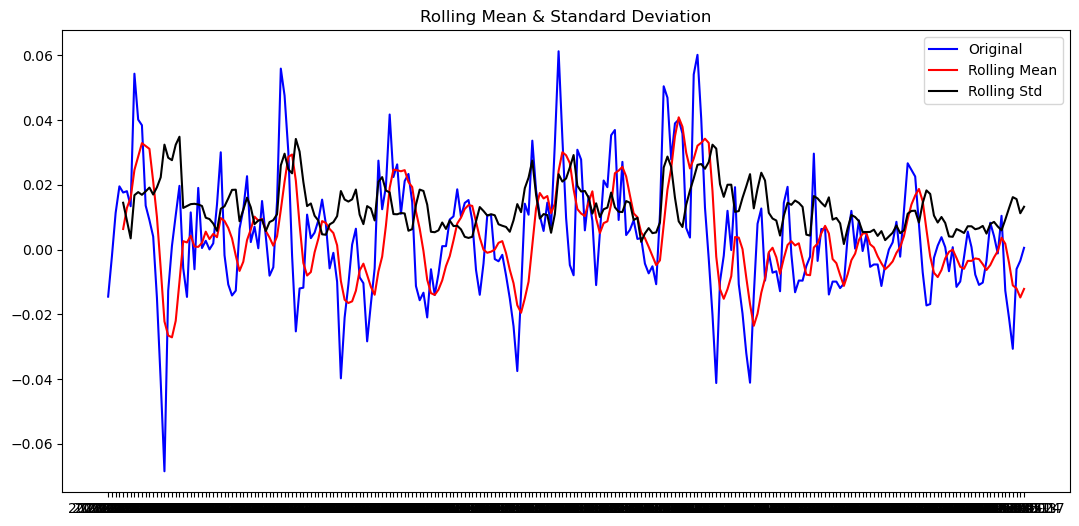

In [25]:
plot_rolling_statistics(sam_log_mov_avg_shift, window=5)

차분까지 실행한 결과, 오히려 p-value는 다시 높아졌고, 시각적으로 비교하여도 그래프는 더욱 요동치기 시작하였다. 이미 충분히 stationary하게 만들었음에도 차분을 추가로 적용할 때 오히려 역효과를 내는 것을 확인할 수 있었다.